In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import enum
import os

import sys
# sys.path.append( '/content/drive/My Drive/thesis-workspace' ) # drive version
sys.path.append( '../src/' ) # local version

from ml.preprocessing import *

# Classification

## Loading Datasets

In [2]:
class DF( enum.Enum ):
    _FULL = 1
    _REDUCED_RFE = 2
    _REDUCED_KBEST = 3
    _MIN = 4

# path = [ '.', 'drive', 'My Drive', 'thesis-workspace', 'datasets' ]
path = [ '..', 'datasets' ]

df = {}
df[ DF._FULL ] = pd.read_csv( os.path.join( *path, 'ds-residential-selection-full.csv' ) , index_col = 'date', parse_dates = [ 'date' ] )
df[ DF._REDUCED_RFE ] = pd.read_csv( os.path.join( *path, 'ds-residential-selection-rfe.csv' ), index_col = 'date', parse_dates = [ 'date' ] )
df[ DF._REDUCED_KBEST ] = pd.read_csv( os.path.join( *path, 'ds-residential-selection-kbest.csv' ), index_col = 'date', parse_dates = [ 'date' ] )
df[ DF._MIN ] = pd.read_csv( os.path.join( *path, 'ds-residential-selection-min.csv' ), index_col = 'date', parse_dates = [ 'date' ] )

## Data splitting, standarization and balancing

In [3]:
from imblearn.over_sampling import ADASYN
from collections import Counter


# Number of neighbors to use for balancing each dataset

neighbors = { 
    DF._FULL: 1,
    DF._REDUCED_RFE: 1,
    DF._REDUCED_KBEST: 1,
    DF._MIN: 1
}

for k, d in df.items() :  
    temp = list( split_data( d, test_size = 0.20 ) )
    temp[ X_TRAIN ], temp[ X_TEST ] = standardize( temp[ X_TRAIN ], temp[ X_TEST ] )
    
    print( 'Before balancing:', k, Counter( temp[ Y_TRAIN ] ) )
    temp[ X_TRAIN ], temp[ Y_TRAIN ] = balance_df( 
        temp[ X_TRAIN ], 
        temp[ Y_TRAIN ], 
        neighbors[ k ] )
    print( 'After balancing:', k, Counter( temp[ Y_TRAIN ] ) )
    print()
    
    df[ k ] = temp

Before balancing: DF._FULL Counter({'L': 16301, 'E': 4128, 'M': 2832, 'H': 531})
After balancing: DF._FULL Counter({'E': 16572, 'M': 16402, 'H': 16391, 'L': 16301})

Before balancing: DF._REDUCED_RFE Counter({'L': 16301, 'E': 4128, 'M': 2832, 'H': 531})
After balancing: DF._REDUCED_RFE Counter({'M': 16326, 'L': 16301, 'E': 16288, 'H': 16281})

Before balancing: DF._REDUCED_KBEST Counter({'L': 16301, 'E': 4128, 'M': 2832, 'H': 531})
After balancing: DF._REDUCED_KBEST Counter({'M': 16362, 'L': 16301, 'H': 16281, 'E': 16256})

Before balancing: DF._MIN Counter({'L': 16325, 'E': 4098, 'M': 2830, 'H': 547})
After balancing: DF._MIN Counter({'E': 16353, 'M': 16330, 'H': 16329, 'L': 16325})



## Training

In [6]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier
from ml.classification import *

params_dt = [ { 
    'criterion': [ 'gini', 'entropy' ], 
    'max_depth': [ 2, 3, 4, 6, 8, 10, 11, 12 ]
} ]

grids = { DF._FULL: None, DF._REDUCED_RFE: None, DF._REDUCED_KBEST: None, DF._MIN: None }

labels = [ 'E', 'H', 'L', 'M' ]

# exclude = [ DF._REDUCED_RFE, DF._REDUCED_KBEST, DF._MIN ]
exclude = [  ]

### Regular

Dataset  DF._FULL 4
Best params:  {'criterion': 'gini', 'max_depth': 12}
Training Accuracy 0.9667407814601674
Test Accuracy:  0.944192301227097
Test ROCauc (OvR): 0.9808303838378056

Detailed Classification Report
              precision    recall  f1-score   support

           E       0.85      0.97      0.91       998
           H       0.91      0.94      0.92       156
           L       0.99      0.93      0.96      4068
           M       0.88      0.96      0.92       727

    accuracy                           0.94      5949
   macro avg       0.91      0.95      0.93      5949
weighted avg       0.95      0.94      0.95      5949


Dataset  DF._REDUCED_RFE 4
Best params:  {'criterion': 'gini', 'max_depth': 12}
Training Accuracy 0.9812411878633199
Test Accuracy:  0.9562951756597747
Test ROCauc (OvR): 0.9815045165104681

Detailed Classification Report
              precision    recall  f1-score   support

           E       0.87      0.97      0.92       998
           H       

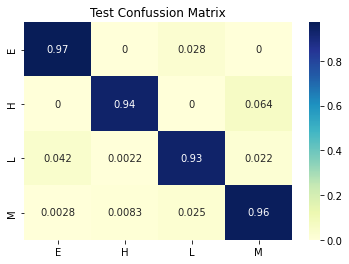

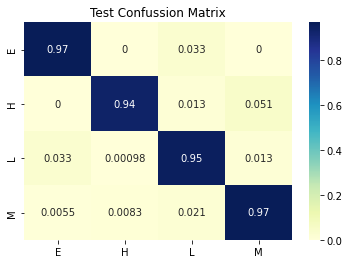

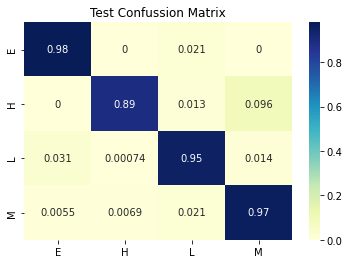

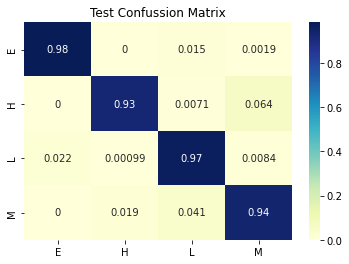

In [7]:
%%time
for k, d in df.items():
    if( k not in exclude ):
        print( 'Dataset ', k, len( d ) )
        grids[ k ] = train_and_test( 
                DecisionTreeClassifier(), params_dt, 
                d[ X_TRAIN ], d[ Y_TRAIN ], 
                d[ X_TEST ], d[ Y_TEST ], 
                plot_cmatrix = True, labels = labels )

Con los datasets sin PCA, SVM y DT no mostraron diferencia en el accuracy entre el dataset con features extra y el dataset reducido. Por su parte KNN si hubo un incremento utilizando el dataset con features reducidos. Para el escenario donde se aplicó PCA antes de realizar la clasificación, nuevamente SVM no se mostró afectado, sin embargo DT y KNN si mostraron una diferencia positiva en el accuracy usando el dataset con features reducidos. El peor caso fue con KNN, donde se obtuvo una diferencia de 5 puntos porcentuales entre el dataset reducido (0.99) y el el dataset extendido (0.95). En general concluimos que el dataset extendido presenta signos de overfitting ya que en general los features agregados no tuvieron impacto o impactaron negativamente en el performance. 

# Evaluation

In [8]:
from ml.evaluation import *

## Learning Curves

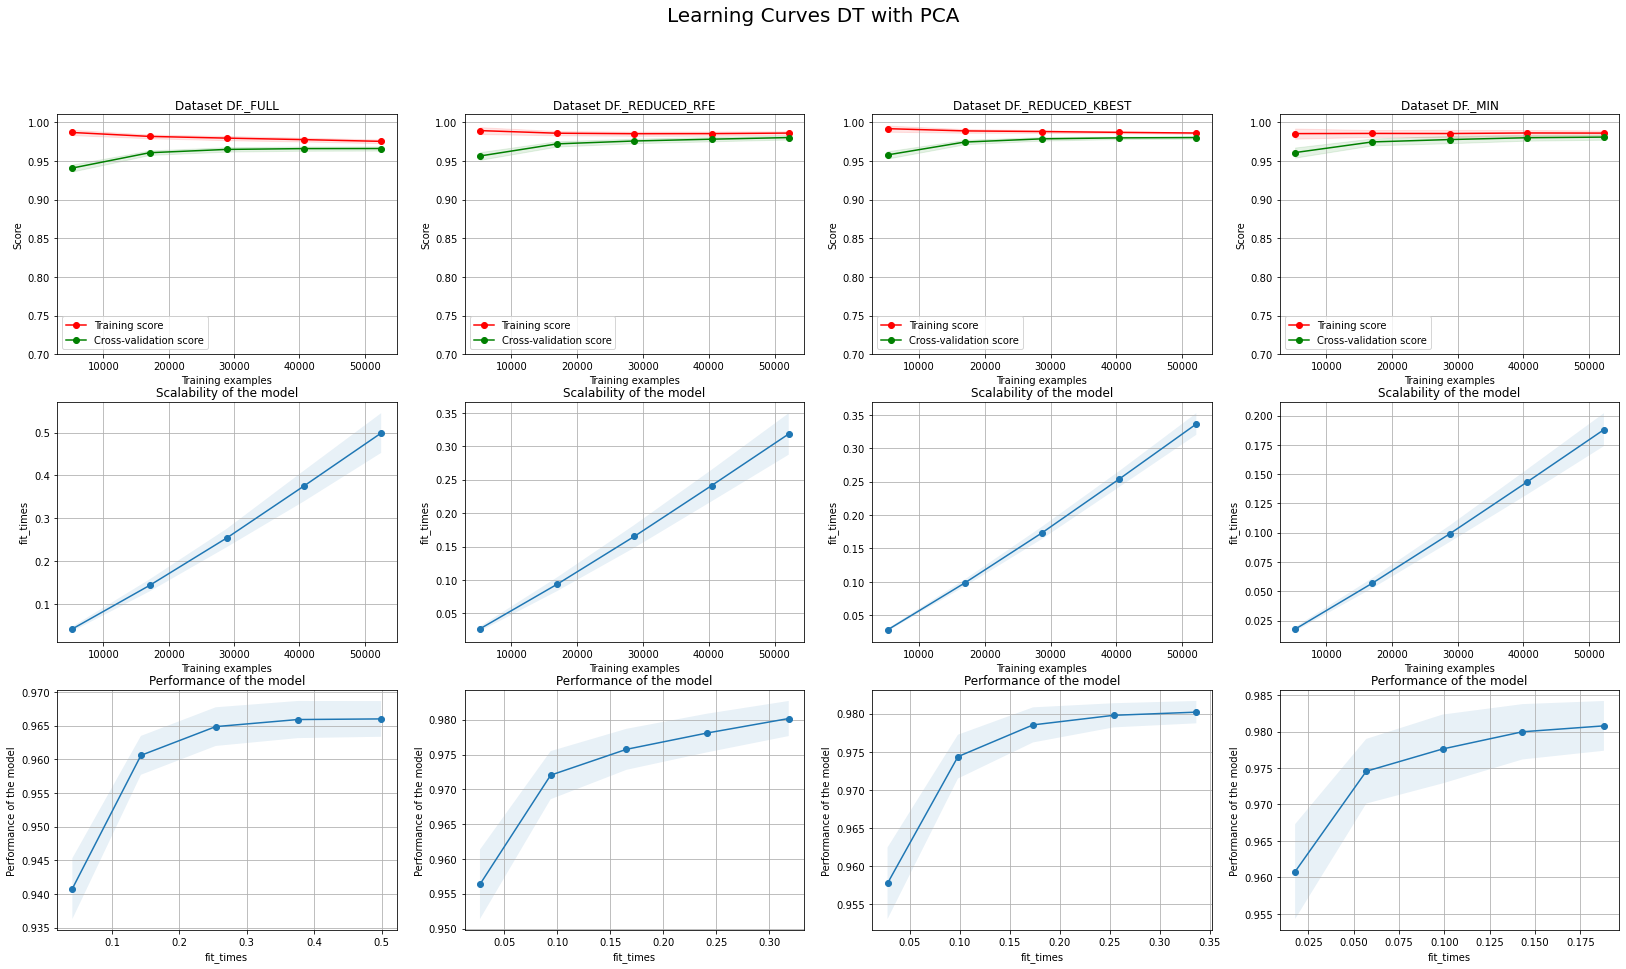

CPU times: user 15.3 s, sys: 660 ms, total: 16 s
Wall time: 2min 1s


In [10]:
%%time
temp = [ item for item in df.items() if item[ 0 ] not in exclude ]
plot_learning_curves( temp, grids, 'DT' )